"Avatar-Net: Multi-scale Zero-shot Style Transfer by Feature Decoration"
==

**Author**: `Minseong Kim` (tyui592@gmail.com)


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
device = torch.device('cuda')
import matplotlib.pyplot as plt

from network import AvatarNet
from utils import imload, maskload, imshow

### Load Check Point

In [2]:
path = 'check_point.pth'

check_point = torch.load(path)

### Training Loss

In [3]:
loss_seq = check_point['loss_seq']

plt.figure(figsize=(10, 5))
for key, value in loss_seq.items():
    plt.semilogy(value, label=key)
plt.xlabel("Training Iteration"); plt.ylabel("Loss")

plt.grid()
plt.legend()
plt.title("Training Loss")
plt.show()    

### Load Network

In [4]:
network = AvatarNet().to(device)
network.load_state_dict(check_point['state_dict'])

<All keys matched successfully>

### Stylize multiple content and style images

In [5]:
content_images = [
    'sample_images/content/avril.jpg', 
    'sample_images/content/brad_pitt.jpg', 
    'sample_images/content/karya.jpg', 
    'sample_images/content/sailboat.jpg']

style_images = [
    'sample_images/style/candy.jpg', 
    'sample_images/style/brick.jpg', 
    'sample_images/style/starry_night.jpg', 
    'sample_images/style/yellow_sunset.jpg']

imsize, cropsize, cencrop = 512, 512, True

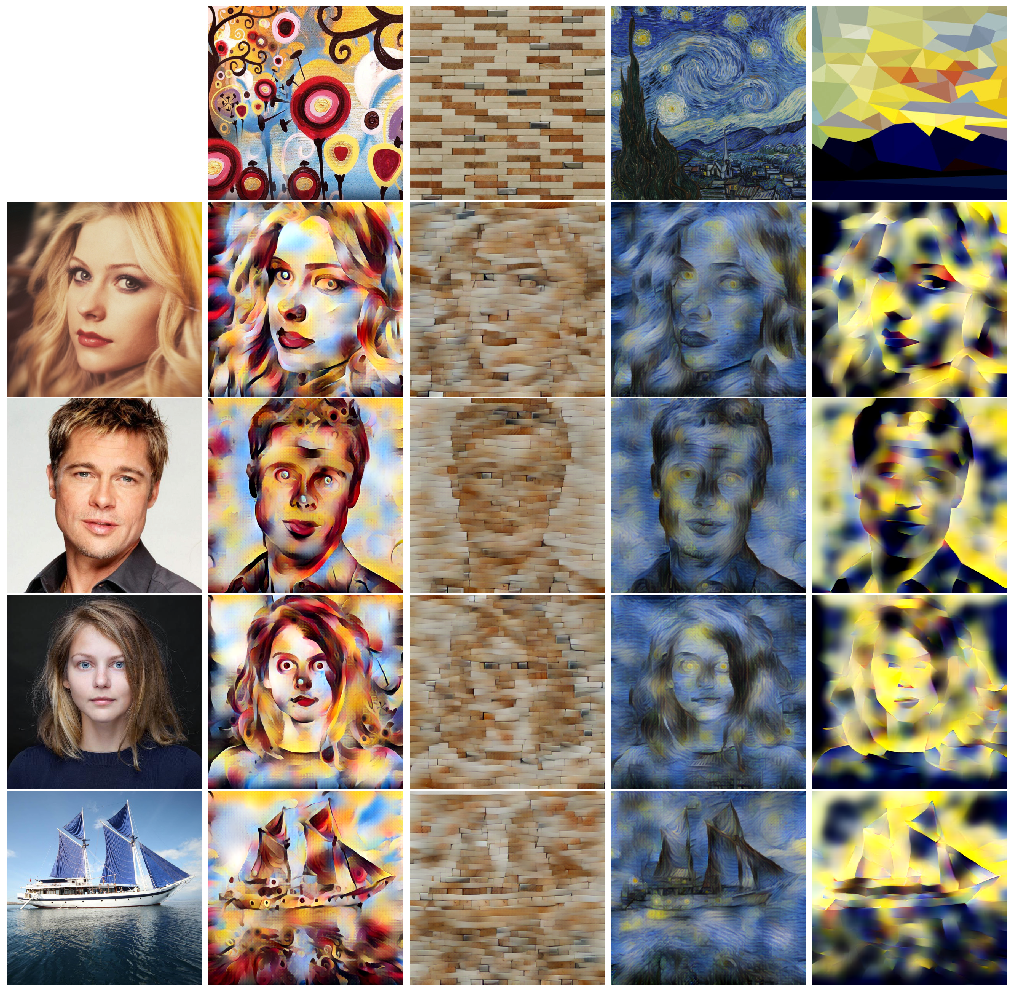

In [6]:
plt.figure(figsize=(18,18)); plt.subplots_adjust(wspace=0.01, hspace=0.01)
count = 6
for content_index, content in enumerate(content_images, 1):
    content_img = imload(content, imsize=imsize, cropsize=cropsize, cencrop=cencrop).to(device)    
    plt.subplot(5,5, 6+5*(content_index-1)); plt.imshow(imshow(content_img)); plt.axis('off')    
    count += 1
    for style_index, style in enumerate(style_images, 2): 
        style_img = imload(style, imsize=imsize, cropsize=cropsize, cencrop=cencrop).to(device)
        if content_index == 1:
            plt.subplot(5,5, style_index); plt.imshow(imshow(style_img)); plt.axis('off')        
        with torch.no_grad():
            stylized_img = network(content_img, [style_img])
            plt.subplot(5, 5, count); plt.imshow(imshow(stylized_img)); plt.axis('off')
            count += 1
plt.savefig('stylization.jpg', bbox_inches='tight', quality=100, dpi=350)            
plt.show()

### Content vs Style Interpolation

In [7]:
content_path = 'sample_images/content/blonde_girl.jpg'
style_path = 'sample_images/style/mondrian.jpg'
imsize, cropsize, cencrop = 512, 512, True

content_img = imload(content_path, imsize, cropsize, cencrop).to(device)
style_img = imload(style_path, imsize, cropsize, cencrop).to(device)

In [8]:
plt.figure(figsize=(20, 5)); plt.subplots_adjust(wspace=0.01)
for count, style_strength in enumerate([a/10 for a in range(0,11,2)], 2):
    with torch.no_grad():
        stylized_img = network(content_img, [style_img], style_strength=style_strength)
        plt.subplot(1, 8, count); plt.imshow(imshow(stylized_img)); plt.title("Style strength: %1.1f"%style_strength); plt.axis('off')
plt.subplot(1, 8, 1); plt.imshow(imshow(content_img)); plt.title("Content"); plt.axis('off')
plt.subplot(1, 8, 8); plt.imshow(imshow(style_img)); plt.title("Style"); plt.axis('off')
plt.savefig('content_style_interpolation.jpg', bbox_inches='tight', quality=100, dpi=350)
plt.show()

### Multiple Style Interpolatoin

In [9]:
content_path = 'sample_images/content/blonde_girl.jpg'
style_paths = ['sample_images/style/mondrian.jpg', 'sample_images/style/abstraction.jpg']
imsize, cropsize, cencrop = 512, 512, True

content_img = imload(content_path, imsize, cropsize, cencrop).to(device)
style_imgs = [imload(style_path, imsize, cropsize, cencrop).to(device) for style_path in style_paths]

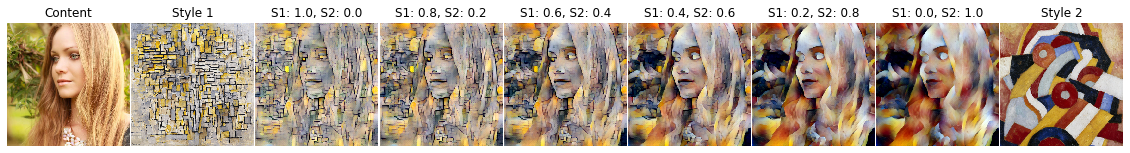

In [10]:
plt.figure(figsize=(20, 5)); plt.subplots_adjust(wspace=0.01)
for count, alpha in enumerate([a/10 for a in range(0,11,2)], 3):
    with torch.no_grad():
        stylized_img = network(content_img, style_imgs, style_strength=1.0, interpolation_weights=[1-alpha, alpha])
        plt.subplot(1, 9, count); plt.imshow(imshow(stylized_img)); plt.title("S1: %1.1f, S2: %1.1f"%(1-alpha, alpha)); plt.axis('off')
plt.subplot(1, 9, 1); plt.imshow(imshow(content_img)); plt.title("Content"); plt.axis('off')
plt.subplot(1, 9, 2); plt.imshow(imshow(style_imgs[0])); plt.title("Style 1"); plt.axis('off')
plt.subplot(1, 9, 9); plt.imshow(imshow(style_imgs[1])); plt.title("Style 2"); plt.axis('off')
plt.savefig('multiple_style_interpolation.jpg', bbox_inches='tight', quality=100, dpi=350)
plt.show()

### Masked stylization

In [11]:
content_path = 'sample_images/content/blonde_girl.jpg'
style_paths = ['sample_images/style/mondrian.jpg', 'sample_images/style/abstraction.jpg']
mask_paths = ['sample_images/mask/blonde_girl_mask1.jpg', 'sample_images/mask/blonde_girl_mask2.jpg']
imsize= 512

content_img = imload(content_path, imsize).to(device)
style_imgs = [imload(style_path, imsize).to(device) for style_path in style_paths]
mask_imgs = [maskload(mask_path).to(device) for mask_path in mask_paths]

In [12]:
plt.figure(figsize=(20, 5)); plt.subplots_adjust(wspace=0.01)
with torch.no_grad():
    stylized_img = network(content_img, style_imgs, masks=mask_imgs, style_strength=1.0, interpolation_weights=[1, 1])
plt.subplot(1, 6, 1); plt.imshow(imshow(content_img)); plt.title("Content"); plt.axis('off')
plt.subplot(1 ,6, 2); plt.imshow(plt.imread(mask_paths[0]), 'gray'); plt.title("Mask 1"); plt.axis('off')
plt.subplot(1 ,6, 3); plt.imshow(plt.imread(mask_paths[1]), 'gray'); plt.title("Mask 1"); plt.axis('off')
plt.subplot(1, 6, 4); plt.imshow(imshow(style_imgs[0])); plt.title("Style 1"); plt.axis('off')
plt.subplot(1, 6, 5); plt.imshow(imshow(style_imgs[1])); plt.title("Style 2"); plt.axis('off')
plt.subplot(1, 6, 6); plt.imshow(imshow(stylized_img)); plt.title("Output"); plt.axis('off')
plt.savefig('masked_stylization.jpg', bbox_inches='tight', quality=100, dpi=350)
plt.show()

### Patch size variation

In [13]:
content_path = 'sample_images/content/blonde_girl.jpg'
style_path = 'sample_images/style/mondrian.jpg'
imsize, cropsize, cencrop = 512, 512, True

content_img = imload(content_path, imsize, cropsize, cencrop).to(device)
style_img = imload(style_path, imsize, cropsize, cencrop).to(device)

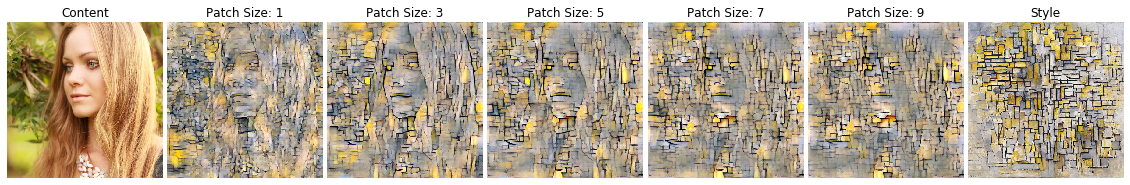

In [14]:
plt.figure(figsize=(20, 5)); plt.subplots_adjust(wspace=0.03)
for count, patch_size in enumerate([1, 3, 5, 7, 9], 2):
    with torch.no_grad():
        stylized_img = network(content_img, [style_img], patch_size=patch_size)
        plt.subplot(1, 7, count); plt.imshow(imshow(stylized_img)); plt.title("Patch Size: %d"%patch_size); plt.axis('off')
plt.subplot(1, 7, 1); plt.imshow(imshow(content_img)); plt.title("Content"); plt.axis('off')
plt.subplot(1, 7, 7); plt.imshow(imshow(style_img)); plt.title("Style"); plt.axis('off')
plt.savefig('patch_size_variation.jpg', bbox_inches='tight', quality=100, dpi=350)
plt.show()

### Patch stride variation

In [15]:
content_path = 'sample_images/content/blonde_girl.jpg'
style_path = 'sample_images/style/mondrian.jpg'
imsize, cropsize, cencrop = 512, 512, True

content_img = imload(content_path, imsize, cropsize, cencrop).to(device)
style_img = imload(style_path, imsize, cropsize, cencrop).to(device)

In [16]:
plt.figure(figsize=(20, 5)); plt.subplots_adjust(wspace=0.03)
for count, patch_stride in enumerate([1, 2, 4], 2):
    with torch.no_grad():
        stylized_img = network(content_img, [style_img], patch_stride=patch_stride)
        plt.subplot(1, 5, count); plt.imshow(imshow(stylized_img)); plt.title("Patch Stride: %d"%patch_stride); plt.axis('off')
plt.subplot(1, 5, 1); plt.imshow(imshow(content_img)); plt.title("Content"); plt.axis('off')
plt.subplot(1, 5, 5); plt.imshow(imshow(style_img)); plt.title("Style"); plt.axis('off')
plt.savefig('patch_stride_variation.jpg', bbox_inches='tight', quality=100, dpi=350)
plt.show()